In [1]:
#   ======================   #
#%% CALCULATION PARAMETERS %%#
#   ======================   #   

orbital = "T2g"

# construction and diagonalization in a single step
onestep = true
# use precomputed spin-CG coefficients
spinarray = true
# parallel computation
distributed = parallel = false
# parallel method: distfor or async
method = "distfor"
# discretization ("standard" or "co2005")
discretization = "co2005"

# twisting parameter
z = 0.0

calculation="IMP"

# command-line input
if length(ARGS)>0
    # clean/imp
    calculation = "IMP"
    if ARGS[1]=="CLEAN" 
        calculation = "CLEAN"
    end
    # twisting parameter
    if length(ARGS)>1
        z = parse(Float64,ARGS[2])
    end
end

# numerical parameters
L = 10.0
betabar = 1.0

iterations = 20

# cutoff
cutoff_type = "multiplet" 
cutoff_magnitude = 10
minmult = 0

# one-particle parameters
eps  = -0.1 
gam  =  0.01
# relative coulomb parameters 
u_11 = 1.0
u_12 = 1.0
j    = 0.0
U_11 = u_11*2*abs(eps)
U_12 = u_12*U_11
J    = j*U_12

# multiplet coulomb parameters
u_a1g = U_11 + 2*J # on-site, orbital-symmetric
u_eg  = U_11 - J   # on-site, orbital-eg 
u_t1g = U_12 - J   # inter-site, spin-aligned
u_t2g = U_12 + J   # inter-site, spin-antialigned

max_spin2 = 10;

distworkers  = 6

println( "====================" )
println( "SETUP AND PARAMETERS" )
println( "====================" )
@show calculation
@show distributed 
distributed && @show distworkers 
@show method
@show eps   
@show u_a1g
@show u_eg
@show u_t1g
@show u_t2g
@show gam  
@show L
@show betabar
@show cutoff_type
@show cutoff_magnitude
@show iterations
@show max_spin2;

SETUP AND PARAMETERS
calculation = "IMP"
distributed = false
method = "distfor"
eps = -0.1
u_a1g = 0.2
u_eg = 0.2
u_t1g = 0.2
u_t2g = 0.2
gam = 0.01
L = 10.0
betabar = 1.0
cutoff_type = "multiplet"
cutoff_magnitude = 10
iterations = 20
max_spin2 = 10


In [2]:
#   =======================   #
#%% MODULES AND DISTRIBUTED %%#
#   =======================   #

using DelimitedFiles
using ProfileVega
using Profile

include( "modules/symbols.jl" )
include( "modules/numericals.jl" )
include( "modules/compoundoperators.jl" )
include( "modules/shell.jl" )
include( "modules/thermo.jl" )
include( "modules/symmetry.jl" );

if parallel 

    using Distributed 

    # remove existing workers
    for i in workers()
        t = rmprocs(i, waitfor=0)
        wait(t)
    end

    # add requested workers
    if distworkers ≥ nprocs()
        addprocs(distworkers)
    else 
        println( "more workers than processors!" )
    end

    println( "DISTRIBUTED CALCULATION WITH $(nworkers()) WORKERS" )

    @everywhere begin 
        using ProgressMeter
        using PartialWaveFunctions
        using StaticArrays
        include( "modules/symmetry.jl" )
        include( "modules/diagonalization.jl" )
    end

else 

    println( "SERIAL CALCULATION" )

    using ProgressMeter
    using PartialWaveFunctions
    using StaticArrays

    include( "modules/symmetry.jl" )
    include( "modules/diagonalization.jl" )

end
println()

SERIAL CALCULATION


In [3]:
#   ======================   #
#%% ORBITAL CLEBSCH-GORDAN %%#
#   ======================   #

CG_PATH = "/home/aitor/Bulegoa/ClebschGordan/Oh/cg_symbolic/"
ASYM_PATH = "/home/aitor/Bulegoa/AntiSymmetricPart/Oh/";

ORBITAL_IRREPS = ( orbital , )
oirreps = cg_shortcircuit( CG_PATH , ORBITAL_IRREPS... )
sort!( oirreps )

#%%
oirreps2indices = Dict( o=>i for (i,o) in enumerate(oirreps) )
oirreps2dimensions = Dict( "Eg" => 2 ,
                           "A1g"=> 1 ,
                           "A2g"=> 1 , 
                           "T1g"=> 3 , 
                           "T2g"=> 3 )
oindex2dimensions = collect( oirreps2dimensions[I] 
                             for I in oirreps )
println( "ORBITAL IRREPS FOR THE PROBLEM" )
println( oirreps )
println()

println( "Computing orbital CG coefficients..." )
@time begin
    global cg_o_full = get_cg_o_fulldict( oirreps , CG_PATH )
    global cg_o_fullmatint = get_cg_o_fullmatint( cg_o_full , oirreps )
end
println()
println( "CLEBSCH-GORDAN MATRIX" )
print_dict( cg_o_fullmatint )
println()


#   ===================   #
#%% SPIN CLEBSCH-GORDAN %%#
#   ===================   #
println( "Computing spin CG coefficients..." )
@time cg_s_fullmatint = get_cg_s_fullmatint( max_spin2 );
println()


#   ==================================   #
#&& ONE-SHELL SYMSTATES AND MULTIPLETS &&#
#   ==================================   #

#   ----------------------- #
#%% basis and hilbert space #
#   ----------------------- #
hilbert_0 = HilbertSpace( T2g_states(0) )
println( "Computing atomic basis..." )
@time basis_0 = CanonicalBasis( hilbert_0 )
println()
println( "BASIS FOR ATOMIC SHELL" )
println( basis_0 )
println()


#   ------------------------ #
#%% symstates and multiplets #
#   ------------------------ #
hiztegia = Dict( 
    "t" =>  "T2g",
    "u" =>  0.5,
    "d" => -0.5
)

print( "Computing atomic symstates..." )
@time begin
    global symstates_0_nor = oneirrep_symstates( 
                                hilbert_0 , 
                                hiztegia , 
                                "A1g" , 
                                "$(ASYM_PATH)$(orbital)_julia/" )
    global symstates_0 = Dict( (q[1:5]...,1)=>s for (q,s) in symstates_0_nor )
end
println( " done" )
println()
println( "ATOMIC SYMSTATES" )
for (k,s) in symstates_0 
    k[1]!==2 && continue
    @show k 
    println( s )
    println()
end
println()

println( "ATOMIC MULTIPLETS" )
multiplets_0 = get_multiplets( symstates_0 )
nmultiplets = collect(multiplets_0) 
sort!( nmultiplets , by=x->x[1] )
for m in nmultiplets
    @show m 
end
println()


#   ---------   #
#%% operators %%#
#   ---------   #
epsilon_symparams = Dict( 
    orbital => eps
)
print( "Computing ϵ operator..." )
@time epsilon = epsilon_sym( symstates_0 , epsilon_symparams ; verbose=false )
println( "done" )
#println()
#println( "EPSILON OPERATOR" )
#print_diagonals( epsilon )

u_symparams = Dict( 
    ("A1g", 0) => [u_a1g][:,:],
    ("Eg",  0) => [u_eg ][:,:],
    ("T1g", 1) => [u_t1g][:,:],
    ("T2g", 0) => [u_t2g][:,:]
)
print( "Computing Coulomb operator..." )
@time coulomb = u_sym( symstates_0 , u_symparams ; verbose=false )
println( " done")
println()
#println( "COULOMB OPERATOR" )
#print_diagonals( coulomb )
#println()


#   -----------------------------   #
#%% atomic hamiltonian (rescaled) %%#
#   -----------------------------   #
H = epsilon + coulomb 
# α = ϵ_0^z (scaling factor)
if discretization=="standard"
    global α = 0.5 * L^z * (1+L^-1)
elseif discretization=="co2005"
    global α = compute_ebar0_z(z,L;discretization=discretization)
end
H.matrix ./= α
gam = sqrt(2.0*gam/pi) / α # for later
#println( "H OPERATOR" )
#print_diagonals( H )
#println()
#hermitize!( H )
#println( "Diagonalizing atomic Hamiltonian without symmetries..." )
#@time (e,u) = diagonalize( H )
#println()
#eigenbasis = GenericBasis( basis_0 , u )
#println( "EIGENENERGIES" )
#println( e )
#println()





ORBITAL IRREPS FOR THE PROBLEM
["A1g", "A2g", "Eg", "T1g", "T2g"]

Computing orbital CG coefficients...
  0.492054 seconds (1.13 M allocations: 65.653 MiB, 3.10% gc time, 90.95% compilation time)

CLEBSCH-GORDAN MATRIX
(4, 5, 5)
ComplexF64[0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im 0.7071067811865476 + 0.0im; 0.0 + 0.0im -0.7071067811865476 + 0.0im 0.0 + 0.0im]

ComplexF64[0.0 + 0.0im 0.0 + 0.0im -0.7071067811865476 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.7071067811865476 + 0.0im 0.0 + 0.0im 0.0 + 0.0im]

ComplexF64[0.0 + 0.0im 0.7071067811865476 + 0.0im 0.0 + 0.0im; -0.7071067811865476 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im]

(5, 4, 3)
ComplexF64[0.5773502691896257 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im -0.28867513459481287 - 0.49999999999999994im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im -0.28867513459481287 + 0.49999999999999994im]

ComplexF64[-0.5773502691896257 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.28867513459481

0.2041330108302195664993204250681900860627157040440535760985304740925275793319776

In [4]:
#   ================================================   #
#&& NUMERICAL ADDITION OF INNERMOST CONDUCTION SHELL &&#
#   ================================================   #

#   -----   #
#%% irreu %%#
#   -----   #
# imp
irreps_0 = get_irreps( symstates_0 )
println( "Diagonalizing atomic Hamiltonian with symmetries..." )
@time irrEU_imp = symdiag( irreps_0 , symstates_0 , H )
println()
println( "irrEU for IMP" )
print_dict( irrEU_imp )
println()
# clean
irrEU_clean = get_irrEU_clean( "A1g" )
println( "irrEU for CLEAN" )
print_dict( irrEU_clean )
println()


#   ---------------   #
#%% combinations u' %%#
#   ---------------   #
combinations_uprima = 
    Dict{ Tuple{Int64,Int64,Int64,Int64} , NTuple{2,Tuple{Int64,Int64,Int64,Int64}} }()
m_vac = (0,oirreps2indices["A1g"],0,1)
#print( "COMBINATIONS U' " )
if calculation=="IMP"
    #println( "for IMP" )
    for m_mu in multiplets_0
        mint_mu = convert_to_int( m_mu , oirreps2indices )
        push!( combinations_uprima , mint_mu=>(mint_mu,m_vac) )
    end 
elseif calculation=="CLEAN" 
    #println( "for CLEAN" )
    push!( combinations_uprima , m_vac=>(m_vac,m_vac) )
end

irreps_uprima = Set( k[1:3] for k in keys(combinations_uprima) )
combinations_uprima = 
        Dict{ NTuple{3,Int64} , Vector{NTuple{3,NTuple{4,Int64}}} }(
            G => NTuple{3,NTuple{4,Int64}}[
                (m_u,m_mu,m_i)
                for (m_u,(m_mu,m_i)) in combinations_uprima 
                if m_u[1:3]==G
                ]
            for G in irreps_uprima
        ) 
println( "COMBINATIONS U' FOR N=0" )
for (G,combs) in combinations_uprima
    println( "$G => $combs" )
end
println()

#   ----------------------   #
#%% pseudo-CG coefficients %%#
#   ----------------------   #
println( "Computing PCG..." )
@time pcg = get_pseudoCG( symstates_0 , basis_0 , hiztegia , oirreps2indices )
println()
#println( "PCG" )
#print_dict( pcg ) 
#println()

# PCG matrix in int format
irrmult_0 = get_irreps( multiplets_0 ; multiplicity=true )
println( "Computing PCG matrix..." )
@time pcgmat = get_pseudoCG_mat( pcg , irrmult_0 , oindex2dimensions , oirreps2indices );
println()


#   -------------------   #
#%% shell cops and qq_a %%#
#   -------------------   #
println( "Computing shell creation operators..." )
@time shell_cops = shell_coperators( basis_0 , hiztegia )
println()
qq_a = collect( convert_to_int(q_a,oirreps2indices) 
                for q_a in keys(shell_cops) )
println( "ONE-PARTICLE HOPPERS" )
@show qq_a;
println()


#   -----------------   #
#%% hopping parameter %%#
#   -----------------   #
hop = Dict( 
    (oirreps2indices["T2g"],1) => ComplexF64(gam)
)
println( "ATOM-SHELL HOPPING PARAMETER" )
@show hop
println()


#   --------------------------   #
#%% block and shell multiplets %%#
#   --------------------------   #
if calculation=="IMP"
    symstates_block = symstates_0 
    multiplets_block = get_multiplets( symstates_block )
    global irrEU = Dict( (convert_to_int(G,oirreps2indices),(E,U))
                   for (G,(E,U)) in irrEU_imp )
    println( "irrEU before adding first shell (to IMP)" )
    for (G,(E,U)) in irrEU 
        @show G, E
    end
    println()
elseif calculation=="CLEAN"
    multiplets_block = Set([(0,"A1g",0.0,1)])
    global irrEU = Dict( (convert_to_int(G,oirreps2indices),(E,U))
                   for (G,(E,U)) in irrEU_clean )
    println( "irrEU before adding first shell (to CLEAN)" )
end 
symstates_shell  = symstates_0 
multiplets_shell = multiplets_0

multiplets_block = Set( convert_to_int(m,oirreps2indices) 
                        for m in multiplets_block )
multiplets_shell = Set( convert_to_int(m,oirreps2indices)
                        for m in multiplets_shell )

println( "BLOCK MULTIPLETS" )
for m in multiplets_block 
    println( m )
end
println()
println( "SHELL MULTIPLETS" )
for m in multiplets_shell 
    println( m )
end
println()

#   ------------------------   #
#%% impurity quantum numbers %%#
#   ------------------------   #

function ordered_multiplets( mults ) 
    max_N = maximum(k[1] for k in mults) 
    omults = []
    for N in 0:max_N 
        for mult in mults
            mult[1]==N || continue
            push!(omults,mult)
        end
    end
    return omults
end

println("IMPURITY MULTIPLET SPACE")
omults = ordered_multiplets(multiplets_block)
mult2index = Dict( m=>i for (i,m) in 
                   enumerate(omults))
mm_i = Dict( 
            m=>[(i==mult2index[m] ? 1.0 : 0.0)
                for i in 1:length(multiplets_block)] 
                for m in omults
           )
@show mm_i 
m_imp = mult_thermo( irrEU ,
                     betabar ,
                     oindex2dimensions ,
                     mm_i )

#   ---------------------------------------   #
#%% matrix construction and diagonalization %%#
#   ---------------------------------------   #
println( "Solving atom + innermost shell..." )
if distributed
    @time begin
    global (irrEU,combinations_uprima) = matdiag_distributed_mat( 
        multiplets_block , 
        multiplets_shell ,
        irrEU , 
        hop , 
        cg_o_fullmatint , 
        cg_s_fullmatint ,
        pcg , 
        pcgmat, 
        qq_a , 
        combinations_uprima , 
        oindex2dimensions ;
        verbose=false );
    end
else
    @time begin
    global (irrEU,combinations_uprima) = matdiag_serial_mat( 
        multiplets_block , 
        multiplets_shell ,
        irrEU , 
        hop , 
        cg_o_fullmatint , 
        cg_s_fullmatint ,
        pcg , 
        pcgmat, 
        qq_a , 
        combinations_uprima , 
        oindex2dimensions ;
        verbose=false );
    end
end

minE = minimum([e for (E,U) in values(irrEU) for e in E])
irrEU = Dict( G=>(E.-minE,U) for (G,(E,U)) in irrEU )
energies = sort([e for (E,U) in values(irrEU) for e in E])

mm_i = imp_mults( irrEU ,
                  oindex2dimensions ,
                  combinations_uprima ,
                  mm_i )
m_imp = mult_thermo( irrEU ,
                     betabar ,
                     oindex2dimensions ,
                     mm_i )
println()


Diagonalizing atomic Hamiltonian with symmetries...
  1.720207 seconds (4.45 M allocations: 272.438 MiB, 8.67% gc time, 99.84% compilation time)

irrEU for IMP
(5, "T2g", 0.5)
([3.837641825494386], ComplexF64[1.0 + 0.0im])

(4, "A1g", 0.0)
([2.0467423069303385], ComplexF64[1.0 + 0.0im])

(3, "A2g", 1.5)
([0.7675283650988765], ComplexF64[1.0 + 0.0im])

(2, "A1g", 0.0)
([-7.101063858213961e-17], ComplexF64[1.0 + 0.0im])

(1, "T2g", 0.5)
([-0.2558427883662923], ComplexF64[1.0 + 0.0im])

(3, "T2g", 0.5)
([0.7675283650988767], ComplexF64[1.0 + 0.0im])

(0, "A1g", 0.0)
([0.0], ComplexF64[1.0 + 0.0im])

(4, "Eg", 0.0)
([2.046742306930339], ComplexF64[1.0 + 0.0im])

(4, "T1g", 1.0)
([2.0467423069303394], ComplexF64[1.0 + 0.0im])

(2, "T1g", 1.0)
([0.0], ComplexF64[1.0 + 0.0im])

(2, "T2g", 0.0)
([-1.775265964553488e-17], ComplexF64[1.0 + 0.0im])

(2, "Eg", 0.0)
([3.550531929106996e-17], ComplexF64[1.0 + 0.0im])

(4, "T2g", 0.0)
([2.046742306930338], ComplexF64[1.0 + 0.0im])

(6, "A1g", 0.0)
([

In [5]:
#   =============   #
#%% NRG PROCEDURE %%# 
#   =============   #

hopchannels = collect(keys( hop ))
@profile global nrg = NRG_mat( iterations , 
           cutoff_type , 
           cutoff_magnitude , 
           L , 
           hopchannels , 
           irrEU , 
           multiplets_shell ,
           cg_o_fullmatint , 
           pcg ,
           pcgmat ,
           qq_a ,
           combinations_uprima ,
           betabar ,
           oindex2dimensions ,
           mm_i ;
           spinarray=spinarray ,
           cg_s_fullmatint=cg_s_fullmatint ,
           z=z ,
           discretization=discretization ,
           distributed=parallel );

NRG PROCEDURE

ITERATION n=2
Applying cutoff to obtain block multiplets...   0.028530 seconds (44.52 k allocations: 2.705 MiB, 97.37% compilation time)
21 multiplets kept (38 states), 711 multiplets discarded
proportion: 2.8688524590163933%. max energy: 0.22469780553152408. max spin: 3
Renormalizing eigenvalues...
shell hopping = 0.9491579967016569872598870061782055794435902459145845959773787545566570511461326
Diagonalizing Hamiltonian...
(ppp.time, ppp.bytes * 10 ^ -6, ppp.gctime) = (0.782141639, 22.633440000000007, 0.0)
m_imp = [0.08838839035527046, 0.6930614378788618, 0.036638521687060305, 0.11406802013373273, 0.02857946358230722, 0.03611917321519238, 6.988444889725407e-5, 2.869317984038541e-5, 0.0007379894048075993, 0.0022873994959982167, 4.205573126724278e-6, 5.916701555078837e-6, 2.2485969648993033e-6, 8.618592883702595e-6, 3.713097770489424e-8, 2.252440277301926e-11]
THERMODYNAMICS
t = 0.55
ρ = 1424.8008724064373
entr = 7.261787344276245
mag = 0.7888869179741742
N = 0.0492554837

In [6]:
#   ===========   #
#%% PERFORMANCE %%#
#   ===========   #

println( "===========" )
println( "PERFORMANCE" )
println( "===========" )
print_performance_onestep(nrg)
println()

PERFORMANCE
TIME (s)
minimum time: 0.045456279
maximum time: 0.782141639
mean time:    0.17327290073684212

minimum gigabytes: 0.00661944
maximum gigabytes: 0.02263344
mean gigabytes:    0.011571193263157895

minimum gc time: 0.0
maximum gc time: 0.011457567
mean gc time:    0.0018744995789473683



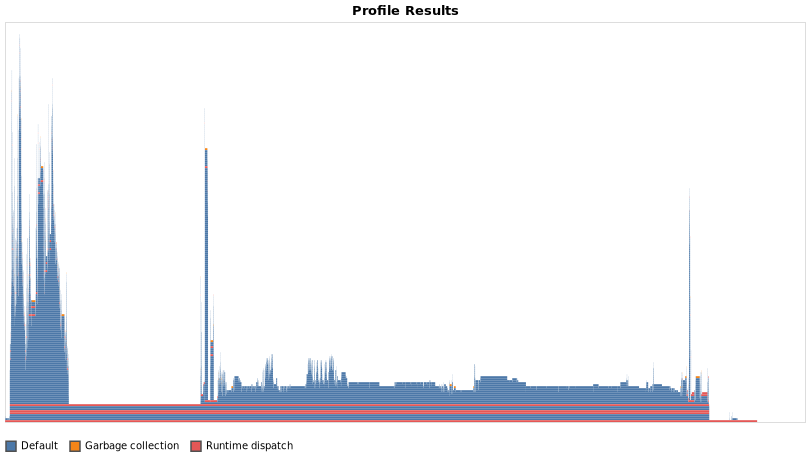

In [7]:
ProfileVega.view()